# **Import Package**

In [256]:
!pip install contractions

In [257]:
!pip install wordcloud

In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

import contractions
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Pre-Processing**

In [290]:
df = pd.read_csv('/content/drive/MyDrive/DBS/ML TERAPAN/Dataset - Train.csv')

In [291]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [292]:
df.shape

(8589, 3)

In [293]:
df.isna().sum()

,0
tweet_text,1
emotion_in_tweet_is_directed_at,5298
is_there_an_emotion_directed_at_a_brand_or_product,0


In [294]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

,count
is_there_an_emotion_directed_at_a_brand_or_product,
No emotion toward brand or product,5389
Positive emotion,2672
Negative emotion,519
I can't tell,9


In [295]:
df.dropna(inplace = True)

In [296]:
df_clean = df.drop_duplicates()

In [297]:
df_clean['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

,count
is_there_an_emotion_directed_at_a_brand_or_product,
Positive emotion,2664
Negative emotion,518
No emotion toward brand or product,91
I can't tell,9


In [298]:
def cleaning(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove mention first before punctuation
    text = re.sub(r"@[\w_]+", "", text) # Remove mention

    # 3. Remove numbers
    text = re.sub(r"\b\d+\b", "", text)

    # 4. Remove URLs
    text = re.sub('https?://\S+|www\.\S+', '', text)

    # 5. Remove HTML tags
    text = re.sub('<.*?>+', '', text)

    # 6. Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # 7. Remove newlines and some extra characters
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)


    # 8. Remove RT and mention literal (optional)
    text = re.sub(r'\brt\b', '', text)
    text = re.sub(r'\bmention\b', '', text)

    # 9. Remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)


    # 10. Fix contractions
    text = contractions.fix(text)

    # 11. Remove stopwords
    stop_list = stopwords.words('english')
    text = ' '.join([word for word in text.split() if word not in stop_list])

    # 12. Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text


In [299]:
df_clean['tweet_text'] = df_clean['tweet_text'].apply(cleaning)

<ipython-input-299-624dfd0c68de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['tweet_text'] = df_clean['tweet_text'].apply(cleaning)


In [300]:
df_clean.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,3g iphone hr tweeting riseaustin dead need upg...,iPhone,Negative emotion
1,know awesome ipadiphone app likely appreciate ...,iPad or iPhone App,Positive emotion
2,wait ipad also sale sxsw,iPad,Positive emotion
3,hope year festival crashy year iphone app sxsw,iPad or iPhone App,Negative emotion
4,great stuff fri sxsw marissa mayer google tim ...,Google,Positive emotion


# **Exploratory Data Analysis**

In [301]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3282 entries, 0 to 8584
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          3282 non-null   object
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  3282 non-null   object
dtypes: object(3)
memory usage: 102.6+ KB


In [302]:
df_clean.shape

(3282, 3)

<ipython-input-303-1d5ef31efd06>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=df_clean, palette = {"Positive emotion": 'green', "Negative emotion": 'red', "No emotion toward brand or product": 'yellow', "I can't tell": "black"})


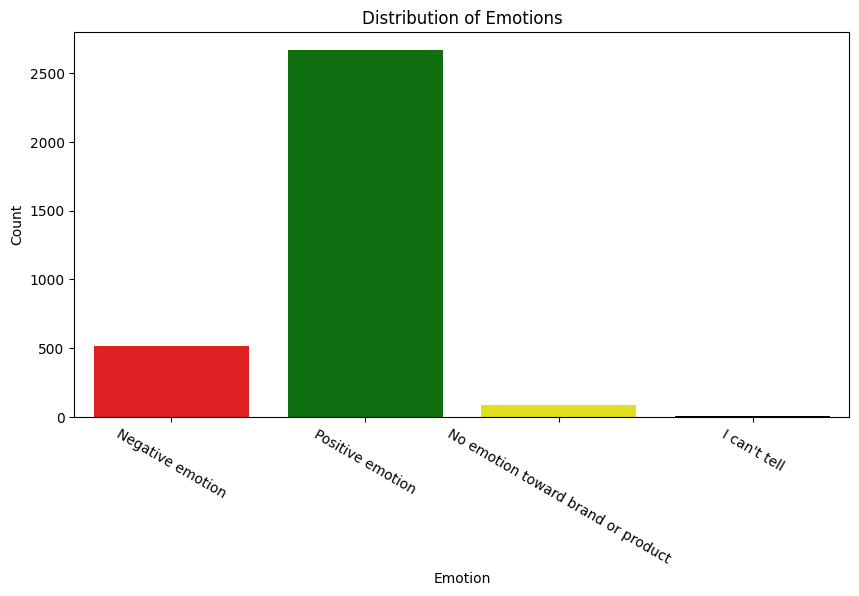

In [303]:
plt.figure(figsize=(10,5))
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=df_clean, palette = {"Positive emotion": 'green', "Negative emotion": 'red', "No emotion toward brand or product": 'yellow', "I can't tell": "black"})
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions')
plt.xticks(rotation=-30)
plt.show()

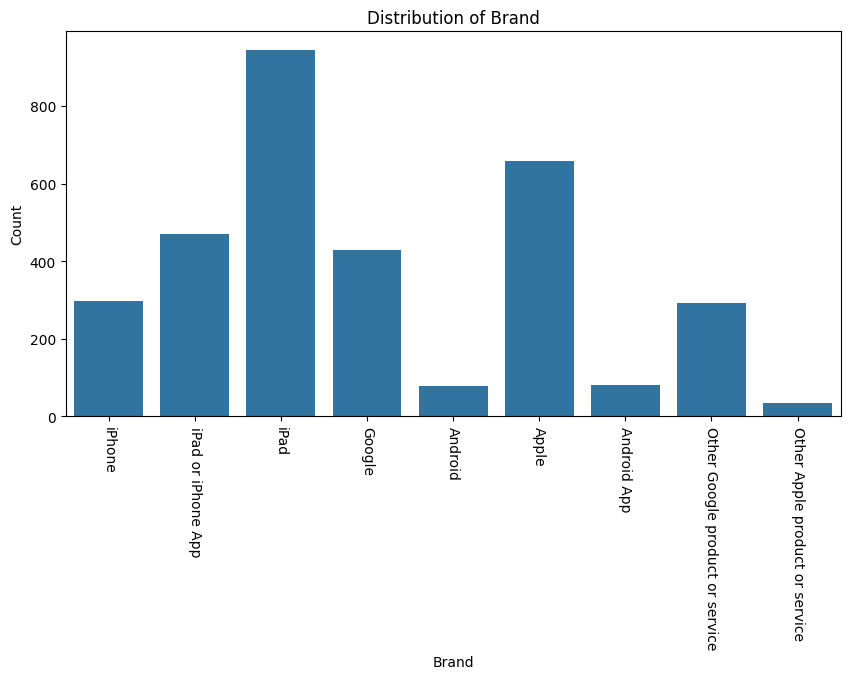

In [304]:
plt.figure(figsize=(10,5))
sns.countplot(x='emotion_in_tweet_is_directed_at', data=df_clean)
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Distribution of Brand')
plt.xticks(rotation=-90)
plt.show()

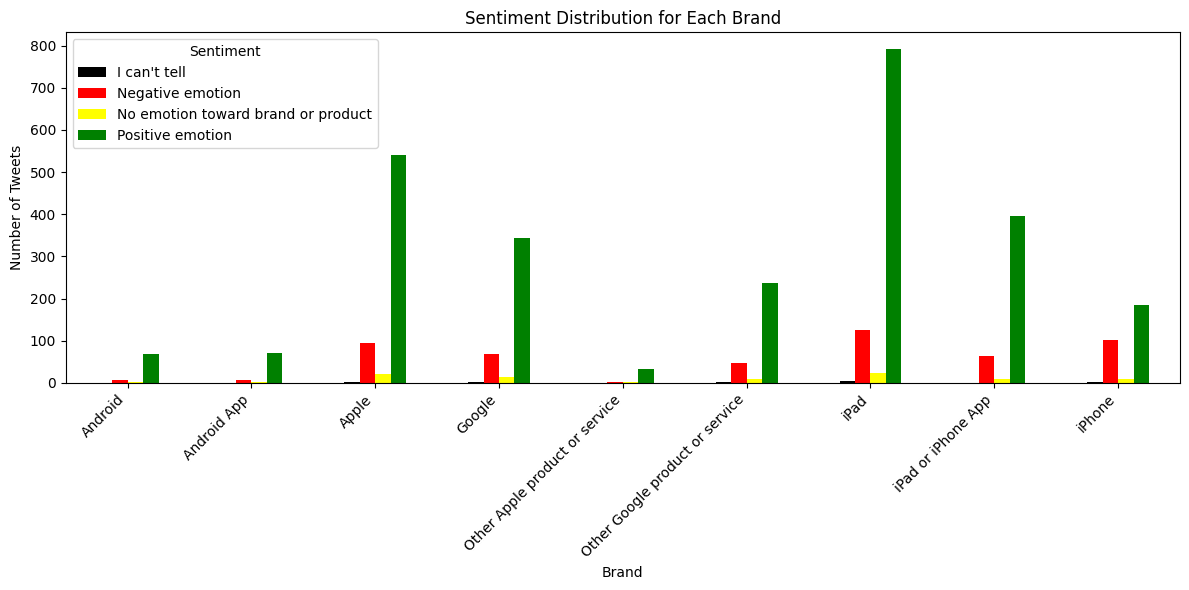

In [305]:
sentiment_counts = df_clean.groupby(['emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']).size().unstack(fill_value=0)

sentiment_counts.plot(kind='bar', stacked=False, figsize=(12, 6), color = {"Positive emotion": 'green', "Negative emotion": 'red', "No emotion toward brand or product": 'yellow', "I can't tell": "black"})
plt.title('Sentiment Distribution for Each Brand')
plt.xlabel('Brand')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [306]:
stop_list = stopwords.words('english')

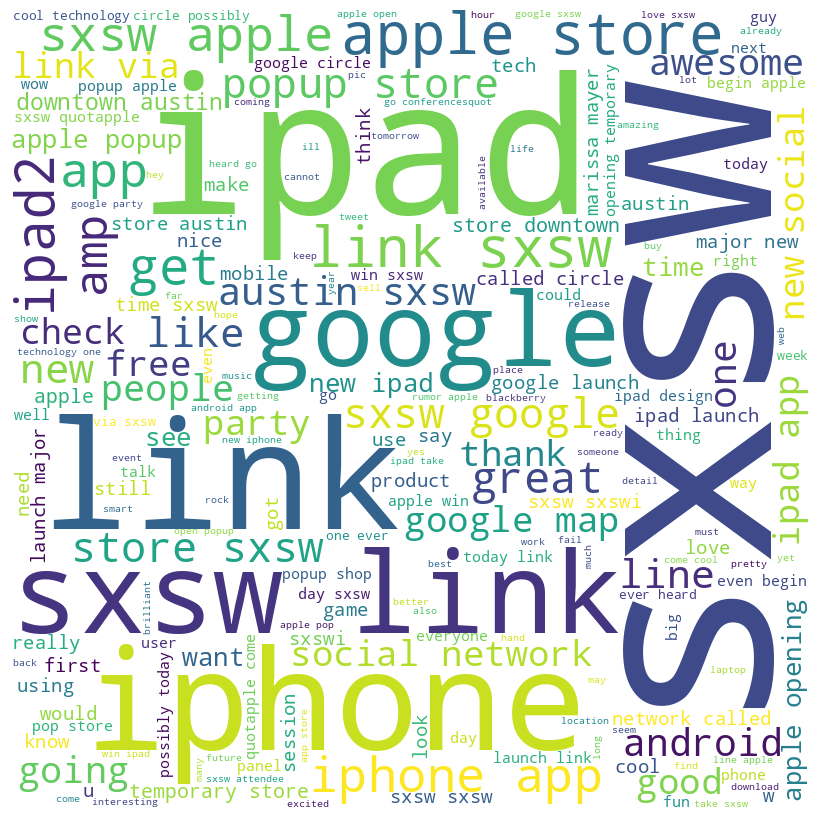

In [307]:
all_tweets = ' '.join(df_clean['tweet_text'])

wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = set(stop_list),
                      min_font_size = 10).generate(all_tweets)

# plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


# **Data Preparation**

In [308]:
df_clean['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

,count
is_there_an_emotion_directed_at_a_brand_or_product,
Positive emotion,2664
Negative emotion,518
No emotion toward brand or product,91
I can't tell,9


In [309]:
df_clean['is_there_an_emotion_directed_at_a_brand_or_product'].replace({"Positive emotion": 1,
                                                                        "Negative emotion": 0,
                                                                        "No emotion toward brand or product": 2,
                                                                        "I can't tell": 2}, inplace=True)
df_clean.head()

<ipython-input-309-384b1ee6e805>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['is_there_an_emotion_directed_at_a_brand_or_product'].replace({"Positive emotion": 1,
<ipython-input-309-384b1ee6e805>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['is_there_an_emotion_directed_at

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,3g iphone hr tweeting riseaustin dead need upg...,iPhone,0
1,know awesome ipadiphone app likely appreciate ...,iPad or iPhone App,1
2,wait ipad also sale sxsw,iPad,1
3,hope year festival crashy year iphone app sxsw,iPad or iPhone App,0
4,great stuff fri sxsw marissa mayer google tim ...,Google,1


In [310]:
df_clean.drop('emotion_in_tweet_is_directed_at', axis=1, inplace=True)

<ipython-input-310-23fa9554b5b1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop('emotion_in_tweet_is_directed_at', axis=1, inplace=True)


In [325]:
tfidf = TfidfVectorizer()
text_count = tfidf.fit_transform(df_clean['tweet_text'])

## Splitting data

In [338]:
X=text_count
y=df_clean['is_there_an_emotion_directed_at_a_brand_or_product']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42, stratify=y)

## Fitting Data

In [394]:
cnb = ComplementNB()
cnb.fit(X_train, y_train)

ComplementNB()

In [395]:
param_dist = {
    'alpha': np.arange(0,1,0.1),
    'norm': [True, False]
}

In [396]:
scorer = make_scorer(f1_score, average='macro')

cnb2 = ComplementNB()

grid_search = GridSearchCV(
    estimator=cnb2,
    param_grid=param_dist,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [397]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=ComplementNB(), n_jobs=-1,
             param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'norm': [True, False]},
             scoring=make_scorer(f1_score, response_method='predict', average=macro),
             verbose=1)

# Evaluation

## Default Parameter

In [398]:
predicted = cnb.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)
print('ComplementNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

ComplementNB model accuracy is 80.21%
------------------------------------------------
Confusion Matrix:
    0    1   2
0  44   52   8
1  28  481  24
2   4   14   2
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.42      0.49       104
           1       0.88      0.90      0.89       533
           2       0.06      0.10      0.07        20

    accuracy                           0.80       657
   macro avg       0.51      0.48      0.48       657
weighted avg       0.81      0.80      0.80       657



In [400]:
f1_score(y_test, predicted, average='macro')

0.4845679012345679

In [401]:
y_test.value_counts()

,count
is_there_an_emotion_directed_at_a_brand_or_product,
1,533
0,104
2,20


In [402]:
519/(y_test.shape[0])

0.7899543378995434

## GridSearchCV

In [403]:
print("Best Params:", grid_search.best_params_)
print("Best F1 Macro Score:", grid_search.best_score_)

Best Params: {'alpha': np.float64(0.4), 'norm': False}
Best F1 Macro Score: 0.4817721924914634


In [404]:
predicted2 = grid_search.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted2, y_test)
print('ComplementNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted2)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted2))

ComplementNB model accuracy is 73.97%
------------------------------------------------
Confusion Matrix:
    0    1   2
0  58   32  14
1  45  425  63
2   6   11   3
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.56      0.54       104
           1       0.91      0.80      0.85       533
           2       0.04      0.15      0.06        20

    accuracy                           0.74       657
   macro avg       0.49      0.50      0.48       657
weighted avg       0.82      0.74      0.78       657



# Inference

In [408]:
def inference(text):
  text = cleaning(text)
  text = tfidf.transform([text])
  prediction = cnb.predict(text)

  if prediction == 1:
    return 'Positive emotion'
  elif prediction == 0:
    return 'Negative emotion'
  else:
    return 'No emotion toward brand or product'

In [409]:
text1 = "Apple has a good technology"
text2 = "Ipad is very useless"

In [410]:
print(f"Text 1: {inference(text1)}\nText 2: {inference(text2)}")

Text 1: Positive emotion
Text 2: Negative emotion
